In [1]:
from rich.console import Console
from rich.syntax import Syntax
from rich.table import Table

def view(item):
    console = Console()
    with console.pager(styles=True):
        console.print(item)

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [44]:
# @markdown ## Required Fields
# @markdown ### Content of the Textbook
book_location = 'bias'
book_content = "Common Biases and Fallacies" #@param {type:"string"}
book_author = "Md. Sazzad Hissain Khan"
# @markdown ### Approximate Number of Pages
n_pages = 20 # @param {"type":"integer","placeholder":"40"}
# @markdown ### Output Format
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = False #@param {type:"boolean"}

# @markdown ## Optional Fields
# @markdown ### Intended Audience
target_readers = "A 2nd-year university student in department of philosophy." #@param {type:"string"}
# @markdown ### Frequency of Equations
equation_frequency_level = 1 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### Consider Chapter Structure and Organization in Content Generation
do_consider_outline = True #@param {type:"boolean"}
# @markdown ### Consider Previous Output in Content Generation
do_consider_previous_sections = True #@param {type:"boolean"}
do_consider_previous_sections_detail = False #@param {type:"boolean"}
# @markdown ### Additional Requirements for Content
additional_requirements = "Try to explain the concept based on factual data." #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'Please specify the content of the textbook.'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'Please specify the number of pages.'+'\033[0m')

In [3]:
import os

if not os.path.exists(book_location):
    os.makedirs(book_location)
os.chdir(book_location)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/hissain/git/github/llmexp/books_prof/bias


## Prompt Definition

In [4]:
# Common Prompt
prompt_common = f"""
You are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: {book_content}.
The total number of pages in the book is about {n_pages}, with an estimated 40 lines per page. Please consider using polite and professional tone.
"""

if target_readers != "":
    prompt_common += f"The intended readers of the book are as follows:\n {target_readers}"
    
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above given information, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed. 
Please do not include any extra introductory or conclusory message outside the expected json format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like you to create content across {n_pages} pages, assuming 20 lines per page.
The summary for this section is as follows:
{section_summary}

Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles. 
Please do not include any extra introductory or conclusory message outside the expected format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """

As part of that, Now, you are writing the book of the title: {book_title} and the summary of the book is as follows:
{book_summary}

The outlines of the book are as follows:
{toc_and_summary}

{previous_sections}.

Now, I would like you to create LaTeX content for the current section on: {target}, across {n_pages} pages, assuming 20 lines per page. 
The summary for the current section whose content you will generate is as follows: {section_summary}. Please generate the content.

Please output the content in the following format:
- Enclose the LaTeX content strictly between the delimiters `<|tex_start|>` and `<|tex_end|>`, as shown below:
    - The LaTeX output **must start with** `<|tex_start|>` delimiter.
    - The LaTeX output **must end with** `<|tex_end|>` delimiter.
- Do not include any other messages, comments, or text outside these delimiters.
- If you have equations in generated response, for equations, use the `equation` or `align` environment; do not use nested environments. Avoid enclosing `align` blocks within additional brackets (e.g., `\[ ... \]`).
- For programming code, use the `lstlisting` environment with the appropriate language option (e.g., `[language=Python]`).
- Escape special characters `&` as `\&` to ensure valid LaTeX.
- Do not include backtick sequences or any unrelated formatting not part of LaTeX syntax.
- Use the `<|tex_start|>` and `<|tex_end|>` delimiters **only once** in the output response: at the beginning and at the end of the response respectively.

Output format:
    <|tex_start|>
    tex response.
    <|tex_end|>
"""

## Parameter Settings

In [5]:
# Parameters
max_depth = 2  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

## Library Installation and Import

In [6]:
#!apt-get update
#!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt-get install -y latexmk
#!apt-get install -y texlive-latex-extra
#!apt-get install -y texlive-science
#%pip install -qU langchain-openai
#%pip install pygraphviz
#%pip install pylatex

import os
import re
import json
import networkx as nx
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

## Graph Creation

In [7]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

In [8]:
view(book_graph.graph)

{
    'book_content': 'Common Biases and Fallacies',
    'target_readers': 'A 2nd-year university student in department of philosophy.',
    'equation_frequency_level': 1,
    'additional_requirements': 'Try to explain the concept based on factual data.'
}


## Title and Chapter Creation

### Function Definition

In [9]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # Convert to JSON format
                json_data = json.loads(json_string)
                view(json_data)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [10]:
def log_prompt(log):
    #print("Prompt text: " + str(log))
    return log

In [11]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

llm = OllamaLLM(base_url='http://localhost:11434', model="llama3.2:latest")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | (lambda x: log_prompt(x)) | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
   }
)

book_json = extract_book_and_chapter_contents(result)

{
    'title': 'Common Biases and Fallacies: A Critical Examination',
    'summary': 'This book provides a comprehensive overview of common biases and fallacies in various fields, 
including philosophy, psychology, economics, and politics. The primary objectives of this book are to educate 
readers on the nature and consequences of these errors, equip them with critical thinking skills to recognize and 
avoid them, and explore ways to mitigate their impact. The scope of this book covers various types of biases and 
fallacies, including cognitive biases, emotional biases, logical fallacies, and epistemic fallacies. The content 
delves into the history, philosophy, and psychological explanations behind these errors, as well as their 
implications for decision-making, policy-making, and everyday life. Throughout the book, readers will find 
practical examples, case studies, and thought-provoking exercises to reinforce their understanding of these 
concepts. With a focus on clarity, accura

### Storing Results in the Book Graph

In [12]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [13]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)



 ## Title: Common Biases and Fallacies: A Critical Examination (Page Count: 20)
 This book provides a comprehensive overview of common biases and fallacies in various fields, including philosophy, psychology, economics, and politics. The primary objectives of this book are to educate readers on the nature and consequences of these errors, equip them with critical thinking skills to recognize and avoid them, and explore ways to mitigate their impact. The scope of this book covers various types of biases and fallacies, including cognitive biases, emotional biases, logical fallacies, and epistemic fallacies. The content delves into the history, philosophy, and psychological explanations behind these errors, as well as their implications for decision-making, policy-making, and everyday life. Throughout the book, readers will find practical examples, case studies, and thought-provoking exercises to reinforce their understanding of these concepts. With a focus on clarity, accuracy, and objectivity, this book aims to equip readers with the knowledge and skills necessary to navigate complex information landscapes effectively.
 ### Chapter 1: Introduction to Biases and Fallacies (Page Count: 0.8)
This chapter provides an introduction to the concept of biases and fallacies, defining them and explaining their significance in various fields. It also discusses the importance of recognizing and avoiding these errors to make informed decisions.
 ### Chapter 2: Cognitive Biases: A Psychological Perspective (Page Count: 1.2)
This chapter explores cognitive biases, including heuristics, availability bias, and confirmation bias, discussing their psychological explanations and examples.
 ### Chapter 3: Emotional Biases: Understanding and Managing Emotions (Page Count: 0.8)
This chapter delves into emotional biases, including the affect heuristic and the fundamental attribution error, examining their impact on decision-making and everyday life.
 ### Chapter 4: Logical Fallacies: A Critical Analysis (Page Count: 1.0)
This chapter examines logical fallacies, including ad hominem attacks, straw man arguments, and false dilemmas, discussing their forms, examples, and implications.
 ### Chapter 5: Epistemic Fallacies: The Nature of Knowledge (Page Count: 0.9)
This chapter explores epistemic fallacies, including the problem of induction, confirmation bias, and the Dunning-Kruger effect, discussing their implications for knowledge acquisition and transmission.
 ### Chapter 6: Case Studies: Applying Biases and Fallacies in Real-World Scenarios (Page Count: 1.5)
This chapter presents real-world case studies illustrating the impact of biases and fallacies in decision-making, policy-making, and everyday life.
 ### Chapter 7: Mitigating Biases and Fallacies: Strategies for Critical Thinking (Page Count: 0.8)
This chapter offers practical strategies for recognizing, avoiding, and mitigating biases and fallacies in personal and professional contexts.

## Book Graph Creation

### Function Definition

In [14]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

def extract_section_content(markdown_text):
    pattern = r'<\|tex_start\|>\s*(.*?)\s*<\|tex_end\|>'  # Regex to match custom delimiters
    match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
    if match:
        tex_string = match.group(1)  # Extract content between the delimiters
        return tex_string
    else:
        pattern = r'<\|tex_start\|>\s*(.*?)\s*<\/\|tex_end\|>'  # Regex to match custom delimiters
        match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
        if match:
            tex_string = match.group(1)  # Extract content between the delimiters
            return tex_string
        else:
            print("TeX data not found.")  # Handle cases with missing delimiters
            return markdown_text


def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLM Chapter, Section, Subsection Generation

In [15]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]

            view(child_node)

            if (child_node["needsSubdivision"] or float(child_node["n_pages"]) >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | (lambda x: log_prompt(x)) | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result)
                view(section_json)

                # Create graph nodes and store results
                if section_json:
                    book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                    book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                    # Only set as the next parent if subdivided
                    next_parent_list.append(child_node_name)

            elif depth == (max_depth-1) or (child_node and not child_node["needsSubdivision"]):

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

{
    'title': 'Introduction to Biases and Fallacies',
    'summary': 'This chapter provides an introduction to the concept of biases and fallacies, defining them and 
explaining their significance in various fields. It also discusses the importance of recognizing and avoiding these
errors to make informed decisions.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Cognitive Biases: A Psychological Perspective',
    'summary': 'This chapter explores cognitive biases, including heuristics, availability bias, and confirmation 
bias, discussing their psychological explanations and examples.',
    'n_pages': 1.2,
    'needsSubdivision': True
}


[
    {
        'title': 'What are Cognitive Biases?',
        'summary': 'Cognitive biases refer to systematic errors in thinking and decision-making that arise from 
mental shortcuts, rules of thumb, or heuristics. These biases can lead to inaccurate judgments and flawed 
reasoning.',
        'n_pages': 0.2,
        'needsSubdivision': True
    },
    {
        'title': 'Heuristics: Mental Shortcuts',
        'summary': 'Heuristics are mental shortcuts that simplify complex decisions by relying on rules of thumb or
general principles. While heuristics can be helpful, they can also lead to cognitive biases if not used 
critically.',
        'n_pages': 0.2,
        'needsSubdivision': False
    },
    {
        'title': 'Availability Bias: How We Overestimate Unlikely Events',
        'summary': 'The availability bias occurs when we overestimate the likelihood of an event based on how 
easily examples come to mind. This bias can lead to inaccurate judgments and exaggerated fears.',
   

{
    'title': 'Emotional Biases: Understanding and Managing Emotions',
    'summary': 'This chapter delves into emotional biases, including the affect heuristic and the fundamental 
attribution error, examining their impact on decision-making and everyday life.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Logical Fallacies: A Critical Analysis',
    'summary': 'This chapter examines logical fallacies, including ad hominem attacks, straw man arguments, and 
false dilemmas, discussing their forms, examples, and implications.',
    'n_pages': 1.0,
    'needsSubdivision': True
}


[
    {
        'title': 'Introduction to Logical Fallacies',
        'summary': 'This section introduces the concept of logical fallacies, explaining their definition and 
importance in critical thinking. It also discusses how these fallacies can be used to manipulate arguments and 
deceive others.',
        'n_pages': 0.8,
        'needsSubdivision': True
    },
    {
        'title': 'Ad Hominem Attacks: A Form of Logical Fallacy',
        'summary': 'This section delves into ad hominem attacks, explaining their forms, examples, and implications
in arguments. It also discusses how to recognize and counter these fallacies.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Straw Man Arguments: Manipulating the Argument',
        'summary': 'This section examines straw man arguments, explaining their forms, examples, and implications 
in discussions. It also discusses how to recognize and counter these fallacies.',
        'n_pages': 0.8,
      

{
    'title': 'Epistemic Fallacies: The Nature of Knowledge',
    'summary': 'This chapter explores epistemic fallacies, including the problem of induction, confirmation bias, 
and the Dunning-Kruger effect, discussing their implications for knowledge acquisition and transmission.',
    'n_pages': 0.9,
    'needsSubdivision': False
}


{
    'title': 'Case Studies: Applying Biases and Fallacies in Real-World Scenarios',
    'summary': 'This chapter presents real-world case studies illustrating the impact of biases and fallacies in 
decision-making, policy-making, and everyday life.',
    'n_pages': 1.5,
    'needsSubdivision': True
}


[
    {
        'title': 'The Dunning-Kruger Effect in Politics',
        'summary': 'This case study examines how politicians and pundits often suffer from the Dunning-Kruger 
effect, where they overestimate their knowledge and expertise on complex issues.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Confirmation Bias in Social Media',
        'summary': 'This case study explores how social media platforms can perpetuate confirmation bias, where 
users selectively expose themselves to information that confirms their existing beliefs.',
        'n_pages': 0.7,
        'needsSubdivision': True
    },
    {
        'title': 'Anchoring Bias in Economic Decision-Making',
        'summary': 'This case study demonstrates how the anchoring bias affects economic decision-making, where 
initial values or anchors influence subsequent judgments.',
        'n_pages': 0.9,
        'needsSubdivision': False
    },
    {
        'title': 'Hindsight Bias i

{
    'title': 'Mitigating Biases and Fallacies: Strategies for Critical Thinking',
    'summary': 'This chapter offers practical strategies for recognizing, avoiding, and mitigating biases and 
fallacies in personal and professional contexts.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'What are Cognitive Biases?',
    'summary': 'Cognitive biases refer to systematic errors in thinking and decision-making that arise from mental 
shortcuts, rules of thumb, or heuristics. These biases can lead to inaccurate judgments and flawed reasoning.',
    'n_pages': 0.2,
    'needsSubdivision': True
}


{
    'title': 'Heuristics: Mental Shortcuts',
    'summary': 'Heuristics are mental shortcuts that simplify complex decisions by relying on rules of thumb or 
general principles. While heuristics can be helpful, they can also lead to cognitive biases if not used 
critically.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'Availability Bias: How We Overestimate Unlikely Events',
    'summary': 'The availability bias occurs when we overestimate the likelihood of an event based on how easily 
examples come to mind. This bias can lead to inaccurate judgments and exaggerated fears.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'Confirmation Bias: How We Seek Out Confirming Information',
    'summary': 'The confirmation bias refers to the tendency to seek out information that confirms our existing 
beliefs or hypotheses. This bias can lead to a narrow and inaccurate understanding of the world.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'Introduction to Logical Fallacies',
    'summary': 'This section introduces the concept of logical fallacies, explaining their definition and 
importance in critical thinking. It also discusses how these fallacies can be used to manipulate arguments and 
deceive others.',
    'n_pages': 0.8,
    'needsSubdivision': True
}


{
    'title': 'Ad Hominem Attacks: A Form of Logical Fallacy',
    'summary': 'This section delves into ad hominem attacks, explaining their forms, examples, and implications in 
arguments. It also discusses how to recognize and counter these fallacies.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Straw Man Arguments: Manipulating the Argument',
    'summary': 'This section examines straw man arguments, explaining their forms, examples, and implications in 
discussions. It also discusses how to recognize and counter these fallacies.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'False Dilemmas: A Form of Logical Fallacy',
    'summary': 'This section explores false dilemmas, explaining their forms, examples, and implications in 
decision-making. It also discusses how to recognize and counter these fallacies.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'The Dunning-Kruger Effect in Politics',
    'summary': 'This case study examines how politicians and pundits often suffer from the Dunning-Kruger effect, 
where they overestimate their knowledge and expertise on complex issues.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Confirmation Bias in Social Media',
    'summary': 'This case study explores how social media platforms can perpetuate confirmation bias, where users 
selectively expose themselves to information that confirms their existing beliefs.',
    'n_pages': 0.7,
    'needsSubdivision': True
}


{
    'title': 'Anchoring Bias in Economic Decision-Making',
    'summary': 'This case study demonstrates how the anchoring bias affects economic decision-making, where initial
values or anchors influence subsequent judgments.',
    'n_pages': 0.9,
    'needsSubdivision': False
}


{
    'title': 'Hindsight Bias in Risk Assessment',
    'summary': 'This case study illustrates how hindsight bias leads individuals to overestimate their ability to 
predict outcomes and underestimate the role of chance.',
    'n_pages': 0.6,
    'needsSubdivision': True
}


### LLM Outline Generation

In [16]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The chapter structure of the book is as following.\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, summary, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "summary": summary}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        summary = i_previous_section["summary"]
        prompt += f"Among those book outlines, lets assume, the previous section discussed in this book was titled with `{title}`, and the section summary was as follows: \n{summary}\n"
    return prompt

### LLM Detail TEX Generation

In [17]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "None", "summary": "None"} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
   
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt |  (lambda x: log_prompt(x))  | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"],
        }
    )

    view(result)
    contents_tex = extract_section_content(result)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], node["summary"], previous_sections_content_list)

\<|tex_start|\>

\chapter{Introduction to Biases and Fallacies}

Biases and fallacies are errors in reasoning, thinking, or decision-making that can lead to inaccurate conclusions,
flawed arguments, or poor choices. In this chapter, we will provide an introduction to the concept of biases and 
fallacies, defining them and explaining their significance in various fields.

To recognize and avoid these errors, it is essential to understand the nature of biases and fallacies and how they 
manifest in different contexts. By acknowledging the potential for biases and taking steps to mitigate their 
impact, individuals can make more informed decisions and arrive at more accurate conclusions.

The importance of recognizing and avoiding biases and fallacies cannot be overstated. In today's complex 
information landscape, it is easy to become misinformed or misled by flawed arguments or biased perspectives. By 
developing critical thinking skills and being aware of the potential for biases and f

TeX data not found.
<|tex_start|>
\section{What are Cognitive Biases?}

Cognitive biases refer to systematic errors in thinking and decision-making that arise from mental shortcuts, rules
of thumb, or heuristics. These biases can lead to inaccurate judgments and flawed reasoning.

According to the Dual-Process Theory (Kahneman & Tversky, 1979), there are two types of cognitive processes: System
1 and System 2. System 1 is fast, intuitive, and automatic, while System 2 is slow, deliberate, and effortful. 
Cognitive biases often arise from the overreliance on System 1, leading to suboptimal decision-making.

Some common examples of cognitive biases include:

- Availability heuristic: judging the likelihood of an event based on how easily examples come to mind
- Anchoring bias: relying too heavily on the first piece of information encountered when making a decision
- Hindsight bias: believing, after an event has occurred, that it was predictable

These biases are often unconscious and can

TeX data not found.
<|tex_start|
\section{Heuristics: Mental Shortcuts}
Heuristics are mental shortcuts that simplify complex decisions by relying on rules of thumb or general principles.
While heuristics can be helpful, they can also lead to cognitive biases if not used critically.

Some common heuristics include:

- Availability heuristic: This heuristic relies on how easily examples come to mind, rather than the actual 
probability of an event.
- Representativeness heuristic: This heuristic involves judging the likelihood of an event based on how closely it 
resembles a typical case, rather than on the actual probabilities.
- Anchoring effect: This heuristic occurs when initial values or anchors influence subsequent judgments.

These heuristics can lead to cognitive biases if not used critically. For example, the availability heuristic can 
cause people to overestimate the likelihood of rare events, while the representativeness heuristic can lead to 
flawed judgments about groups ba

TeX data not found.
<|tex_start|>

\chapter{Availability Bias: How We Overestimate Unlikely Events}

The availability heuristic is a cognitive bias that affects our perception of probabilities. It occurs when we 
overestimate the likelihood of an event based on how easily examples come to mind. This bias can lead to inaccurate
judgments and exaggerated fears.

For instance, consider a plane crash. The chances of being in a plane crash are extremely low, but if you have just
experienced a plane crash or know someone who has, you might overestimate the risk.

Another example is the fear of sharks. While shark attacks are rare, the media often sensationalizes these 
incidents, making them seem more common than they actually are. This can lead to an exaggerated perception of the 
threat posed by sharks.

The availability heuristic can be explained by two factors: the vividness and recency effects. The vividness effect
refers to our tendency to overestimate the likelihood of events that are

TeX data not found.
<|tex_start|
\ chapter{Confirmation Bias: How We Seek Out Confirming Information}

The confirmation bias is a cognitive bias that refers to the tendency for individuals to seek out information that 
confirms their existing beliefs, hypotheses, or values. This bias can lead to a narrow and inaccurate understanding
of the world, as well as poor decision-making.

This bias arises from the way our brains process information. When we encounter new information that challenges our
existing beliefs, it can be uncomfortable and even painful. To avoid this discomfort, our brains tend to seek out 
information that confirms what we already believe. This is often referred to as "anchoring" or "reinforcing" our 
existing beliefs.

One reason for the confirmation bias is that our brains are wired to recognize patterns. When we encounter new 
information, our brains search for patterns that fit our existing knowledge and experiences. If the new information
doesn't fit, it may be at

TeX data not found.
<|tex_start|>

\chapter{Emotional Biases: Understanding and Managing Emotions}

The emotional aspect of human decision-making is a complex and multifaceted topic. Emotional biases, which refer to
the ways in which emotions influence our thoughts, feelings, and actions, can have a significant impact on our 
daily lives. In this chapter, we will explore some common emotional biases, including the affect heuristic and the 
fundamental attribution error.

\section{The Affect Heuristic}

The affect heuristic is a cognitive bias that refers to the tendency to make decisions based on how we feel about 
an issue rather than on the actual facts. This bias can lead to irrational decision-making, as we tend to 
overestimate the importance of emotional responses and underestimate the impact of rational considerations.

For example, imagine you are considering buying a new car. You have two options: a sporty red sports car or a 
practical white sedan. If you like the color red, 

<|tex_start|
\ chapter{Introduction to Logical Fallacies}

In the realm of critical thinking, logical fallacies hold a significant place. They are errors in reasoning that 
can lead to misleading conclusions and undermine the validity of an argument. In this chapter, we will delve into 
the world of logical fallacies, exploring their definition, importance, and ways they can be used to manipulate 
arguments.

\ section{Definition and Importance}

Logical fallacies refer to systematic errors in reasoning that result in invalid or misleading conclusions. These 
errors can stem from various sources, including linguistic misunderstandings, cognitive biases, and flawed 
assumptions. Understanding logical fallacies is crucial for effective critical thinking and decision-making.

The importance of recognizing logical fallacies cannot be overstated. By being aware of these errors, individuals 
can avoid falling prey to misleading arguments and make more informed decisions.

\ subsection{Types 

TeX data not found.
\<|tex_start|>

\ chapter{Ad Hominem Attacks: A Form of Logical Fallacy}

 Ad hominem attacks are a type of logical fallacy that involves attacking the character or personal qualities of an
individual rather than addressing the substance of their argument. This approach can be used to discredit someone's
opinion, but it is often considered unfair and unproductive.

 In arguments, ad hominem attacks typically take the form of insults, personal criticisms, or appeals to emotion. 
For example, "You're just saying that because you're in love with John." This response tries to undermine the 
validity of the argument by focusing on a personal aspect of the person making it.

 Ad hominem attacks can be effective in the short term, but they often backfire and damage one's credibility. In 
fact, research has shown that people are less likely to engage with someone who uses ad hominem attacks, even if 
the attack is unjustified.

 So, how can you recognize an ad hominem attac

 <|tex_start|>
\section{Straw Man Arguments: Manipulating the Argument}

A straw man argument is a type of fallacy that involves misrepresenting or exaggerating an opponent's position to 
make it easier to attack. This section examines straw man arguments, explaining their forms, examples, and 
implications in discussions.

In arguments, straw man tactics are often used to create an illusion of disagreement or conflict where none exists.
For instance, when someone presents a well-reasoned argument against a particular policy, an opponent might respond
by misrepresenting the original position as being extreme or unreasonable. By doing so, the opponent can then argue
that their own view is the reasonable one.

Straw man arguments can be particularly insidious because they often involve a combination of misinformation and 
psychological manipulation. The opponent who uses this tactic may try to create a sense of cognitive dissonance in 
the listener by appealing to their emotions or biase

TeX data not found.
<|tex_start|
\chapter{False Dilemmas: A Form of Logical Fallacy}

\section{Introduction to False Dilemmas}

A false dilemma is a logical fallacy that presents only two options as if they are the only possibilities, when in 
fact there may be other alternatives. This fallacy can be particularly misleading because it creates a sense of 
urgency or necessity, making it more difficult for the person being presented with the options to consider 
alternative perspectives.

\section{Forms of False Dilemmas}

There are several forms of false dilemmas, including:

1. **Either-Or Fallacy**: Presents two options as if they are mutually exclusive when in fact they may not be.
2. **True or False Fallacy**: Presents a statement as either true or false without providing context or evidence to
support the claim.
3. **Yes or No Fallacy**: Forces a person to choose between two options, often with a hidden agenda.

\section{Examples of False Dilemmas}

1. A politician says, "If you wa

TeX data not found.
<|tex_start|>

# Epistemic Fallacies: The Nature of Knowledge

## Introduction to Epistemic Fallacies

Epistemic fallacies refer to errors in reasoning that affect the nature and acquisition of knowledge. These 
fallacies can lead to flawed decision-making, incorrect conclusions, and misinformed opinions.

## The Problem of Induction

The problem of induction is a classic epistemic fallacy that arises from assuming that past experiences will 
necessarily determine future outcomes. However, this assumption is based on limited information and ignores the 
complexity of real-world systems.

### Example: The Stock Market

Imagine a historian who observes that every time it rains, the stock market goes up. Based on this pattern, they 
predict that the market will go up tomorrow if it rains again. This conclusion is an example of inductive reasoning
gone wrong, as there are many factors that can influence the market beyond just weather.

### Solution: Recognize Limits of 

<|tex_start|>

\chapter{The Dunning-Kruger Effect in Politics}

In recent years, the phenomenon of political pundits and politicians overestimating their knowledge and expertise 
on complex issues has gained significant attention. This chapter examines how the Dunning-Kruger effect plays out 
in politics, with a focus on its implications for informed decision-making.

The Dunning-Kruger effect is named after the psychologists David Dunning and Justin Kruger, who first described 
this cognitive bias in 1999. According to their research, individuals who are incompetent in a particular domain 
tend to overestimate their own abilities and performance, while underestimating the abilities of others. This 
effect is thought to occur because people lack metacognitive skills, or the ability to reflect on their own thought
processes and evaluate their own knowledge.

In the context of politics, the Dunning-Kruger effect can have significant consequences. For example, a political 
pundit who has 

 <|tex_start|
\ chapter{Confirmation Bias in Social Media}

 Confirmation bias in social media is a pervasive issue that can significantly impact an individual's perception of
reality. This case study explores how social media platforms can perpetuate confirmation bias, where users 
selectively expose themselves to information that confirms their existing beliefs.

Social media algorithms are designed to personalize the user experience by serving content that is likely to engage
and retain users. However, this can also lead to a self-reinforcing cycle of confirmation bias. When users interact
with content that aligns with their pre-existing views, they are more likely to share it with others, which in turn
increases its visibility on the platform.

As a result, social media platforms often curate content that reinforces existing beliefs and opinions, creating an
"echo chamber" effect where users are only exposed to information that confirms their worldview. This can lead to a
narrow an

TeX data not found.
<|tex_start|>

\chapter{Anchoring Bias in Economic Decision-Making}

The anchoring bias is a cognitive heuristic that affects economic decision-making. It occurs when an initial value 
or anchor influences subsequent judgments, often leading to suboptimal choices.

In economics, the anchoring bias can manifest in various ways. For instance, when evaluating the price of a 
product, consumers may rely on the first piece of information they receive, such as the manufacturer's suggested 
retail price (MSRP), rather than considering other relevant factors like market demand or production costs.

A classic example of the anchoring bias in economic decision-making is the "anchoring effect" study conducted by 
psychologists Hillel Schwartz and Amos Tversky. In this experiment, participants were asked to estimate the cost of
a car based on an initial value provided by a salesperson. The results showed that even when presented with 
accurate information about the market price

TeX data not found.
\ chapter{Hindsight Bias in Risk Assessment}
\ section{Understanding the Hindsight Bias}

The hindsight bias, also known as the Kuhn phenomenon, is a cognitive bias that affects our perception of past 
events. It refers to the tendency to believe, after an event has occurred, that we would have predicted it if we 
had been aware of all the relevant information at the time. This bias can lead individuals to overestimate their 
ability to predict outcomes and underestimate the role of chance.

\ subsubsection{The Psychology Behind the Hindsight Bias}

Research suggests that the hindsight bias is closely related to the Dunning-Kruger effect, where individuals who 
are incompetent in a particular domain tend to overestimate their abilities. Additionally, the hindsight bias can 
be influenced by factors such as cognitive dissonance, where individuals seek to reduce feelings of discomfort or 
uncertainty by rationalizing past decisions.

\ subsubsection{Examples and Case 

TeX data not found.
<|tex_start|>
\chapter{Mitigating Biases and Fallacies: Strategies for Critical Thinking}

This chapter offers practical strategies for recognizing, avoiding, and mitigating biases and fallacies in personal
and professional contexts. To develop critical thinking skills, it is essential to understand the types of biases 
and fallacies that can affect our decision-making processes.

\section{Critical Thinking Techniques}

Several techniques can help individuals recognize and avoid biases and fallacies:

\begin{itemize}
    \item Skepticism: Approach information with a healthy dose of skepticism, questioning assumptions and evidence.
    \item Evidence-based reasoning: Base decisions on empirical evidence rather than personal opinions or 
anecdotes.
    \item Active listening: Pay attention to diverse perspectives and engage in open-minded dialogue.
    \item Diverse perspectives: Seek out multiple viewpoints to challenge one's own biases and assumptions.
\end{itemize}

In [32]:
result

"<|tex_start|>\n\\chapter{Mitigating Biases and Fallacies: Strategies for Critical Thinking}\n\nThis chapter offers practical strategies for recognizing, avoiding, and mitigating biases and fallacies in personal and professional contexts. To develop critical thinking skills, it is essential to understand the types of biases and fallacies that can affect our decision-making processes.\n\n\\section{Critical Thinking Techniques}\n\nSeveral techniques can help individuals recognize and avoid biases and fallacies:\n\n\\begin{itemize}\n    \\item Skepticism: Approach information with a healthy dose of skepticism, questioning assumptions and evidence.\n    \\item Evidence-based reasoning: Base decisions on empirical evidence rather than personal opinions or anecdotes.\n    \\item Active listening: Pay attention to diverse perspectives and engage in open-minded dialogue.\n    \\item Diverse perspectives: Seek out multiple viewpoints to challenge one's own biases and assumptions.\n\\end{itemize

## Graph Tree Visualization

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


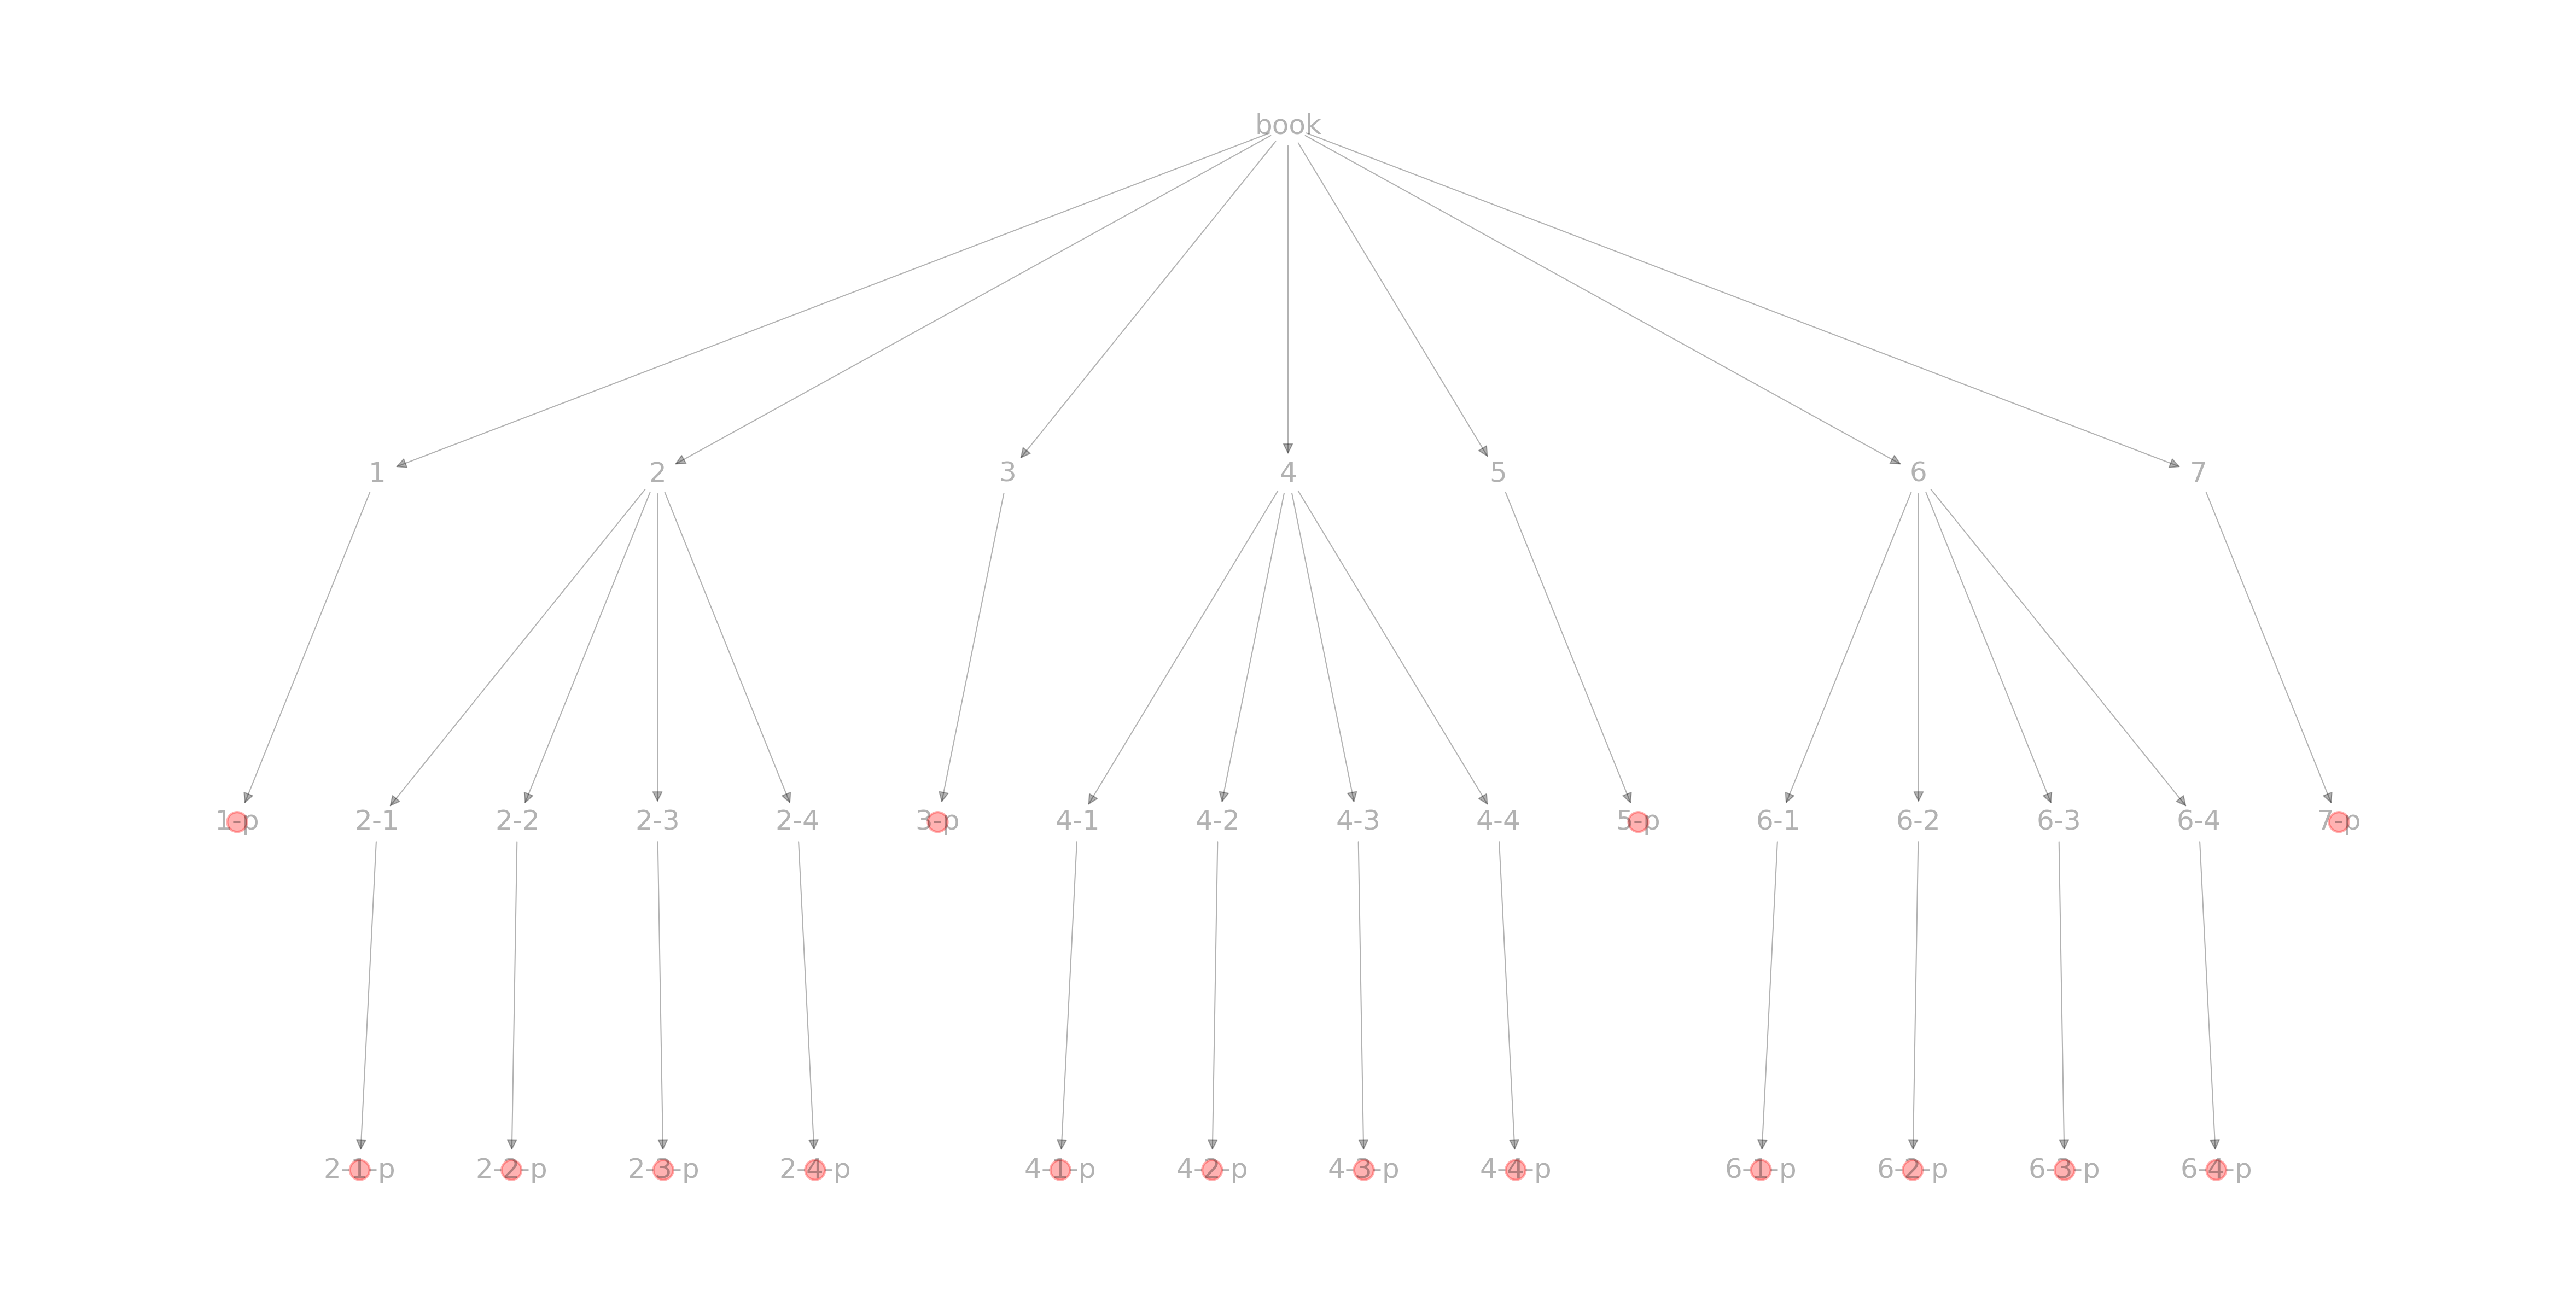

In [33]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## latexmkrc Generation

In [27]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

.latexmkrc file has been created successfully at /Users/hissain/.latexmkrc


## LaTeX Generation Styles Setting

In [37]:
# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))

# Adding title, author, and date to the preamble
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("author", book_author))
doc.preamble.append(Command("date", NoEscape(r"\today")))

# Generating the title and table of contents
doc.append(NoEscape(r"\maketitle"))  # Generates the title with author and date
doc.append(NoEscape(r"\tableofcontents"))

# Setting up custom lstset for listings
doc.append(NoEscape(r'\lstset{backgroundcolor={\color[gray]{.90}}, breaklines=true, breakindent=10pt, basicstyle=\ttfamily\scriptsize, commentstyle={\itshape \color[cmyk]{1,0.4,1,0}}, classoffset=0, keywordstyle={\bfseries \color[cmyk]{0,1,0,0}}, stringstyle={\ttfamily \color[rgb]{0,0,1}}, frame=TBrl, framesep=5pt, numbers=left, stepnumber=1, numberstyle=\tiny, tabsize=4, captionpos=t}'))

In [42]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    try:
        with open(tex_file_path, "r", encoding='UTF-8') as file:
            tex_content = file.read()
            tex_content.replace('\&', '\\&')
            doc.append(NoEscape(tex_content))
    except Exception as e:
        print(e)

## PDF Generation

In [43]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

Latexmk: This is Latexmk, John Collins, 17 March 2019, version: 4.63b.
Rule 'pdflatex': The following rules & subrules became out-of-date:
      'pdflatex'
------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  --interaction=nonstopmode -recorder  "/Users/hissain/git/github/llmexp/books_prof/bias/Common Biases and Fallacies: A Critical Examination.tex"'
------------
Latexmk: applying rule 'pdflatex'...
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/Users/hissain/git/github/llmexp/books_prof/bias/Common Biases and Fallacies: 
A Critical Examination.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/report.cls
Document Class: report 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/fontenc.sty
(/usr/local/texlive/2019/te

## Markdown Generation

In [31]:
def clean_markdown_content(content):
    # Remove the part before the first heading (LaTeX settings section)
    content = content.split('#', 1)[1]

    # Remove % only when it has whitespace before or after
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # Remove % only when it appears at the end of a line
    content = re.sub(r"%\s*$", "", content)

    # Replace multiple newlines with a single newline
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # Convert align and align* environments
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # Convert equation and equation* environments
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # Extract and handle language option
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # Search for language option
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # Convert to Markdown format
        return f'```{lang}\n{code}\n```'

    # Conversion process for lstlisting
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [25]:
# if md_output:
#     %pip install latex2markdown
#     import latex2markdown

#     with open(book_node["title"] + ".tex", "r") as f:
#         latex_string = f.read()

#     # Convert LaTeX to Markdown
#     processed_latex_str = transform_code_blocks(latex_string)
#     l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
#     markdown_string = l2m.to_markdown()

#     # Format the Markdown text
#     cleaned_md_str = clean_markdown_content(markdown_string)
#     katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

#     with open(book_node["title"] + ".md", "w") as f:
#         f.write(katex_md_str)
#     files.download(book_node["title"] + ".md")